In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [17]:
train = pd.read_csv('./data/cleaned/train_final.csv', index_col=0, parse_dates=['start_date'])
test = pd.read_csv('./data/cleaned/test_final.csv', index_col = 0,parse_dates=['start_date'])

We delete some features that can't be handle with encoding

In [18]:
todrop = ['l2', 'l3', 'start_date']
train.drop(todrop, axis=1, inplace=True)
test.drop(todrop, axis=1, inplace=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111372 entries, 0 to 111371
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             111372 non-null  float64
 1   lon             111372 non-null  float64
 2   surface_total   111372 non-null  float64
 3   property_type   111372 non-null  object 
 4   target          111372 non-null  int64  
 5   pileta          111372 non-null  int64  
 6   vigilancia      111372 non-null  int64  
 7   patio           111372 non-null  int64  
 8   garage          111372 non-null  int64  
 9   balcon          111372 non-null  int64  
 10  cancha          111372 non-null  int64  
 11  gimnasio        111372 non-null  int64  
 12  sauna           111372 non-null  int64  
 13  a_estrenar      111372 non-null  int64  
 14  bathrooms_cat   111372 non-null  int64  
 15  bedrooms_cat    111372 non-null  int64  
 16  days_published  111372 non-null  float64
 17  distance_s

In [20]:
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# Create OneHotEncoder: ohe
ohe = OneHotEncoder(sparse=False)
to_transform = ['property_type', 'bathrooms_cat', 'bedrooms_cat']
X = ohe.fit_transform(train[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names_out(to_transform))
train = pd.concat([train, X], axis=1)
train.drop(to_transform, axis=1, inplace=True)

We create a test set to try models

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.2, random_state=42)

### CLASSIFICATION APPROACH
First we try a few common classification algorithms

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/maico/Henry/DeepLearning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/maico/Henry/DeepLearning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

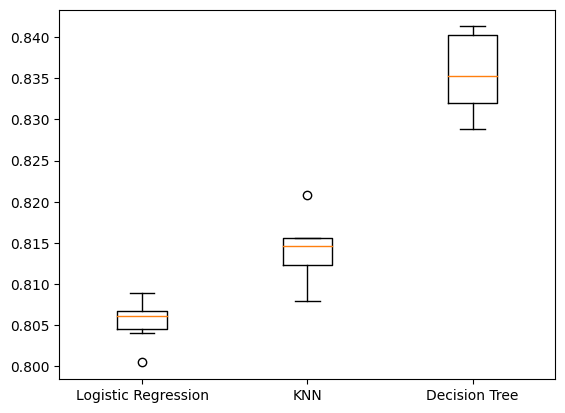

In [37]:
#Looping with cross validation the 3 models
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier()}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)

#Plot with train results
plt.boxplot(results, labels=models.keys())
plt.show()

## DECISION TREE

#### DECISION TREE: GRIDSEARCH CV

In [16]:
# Create steps
steps = [("scaler", StandardScaler()), 
        ("tree", DecisionTreeClassifier(random_state=123))]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"tree__max_depth": [4,6,8,10,12,14],
        "tree__criterion": ["gini", "entropy"],
        "tree__min_samples_leaf": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        "tree__max_features": ["auto", "sqrt", "log2"]
        }

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params, scoring='recall', cv=10, n_jobs=-1)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Decision Tree Classifier Parameters: {}, Recall: {}".format(tuning.best_params_, tuning.score(X_test, y_test)))

Tuned Decision Tree Classifier Parameters: {'tree__criterion': 'entropy', 'tree__max_depth': 14}, Accuracy: 0.8522558922558923


#### DECISION TREE: FINAL MODEL SELECTED

In [17]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=14, random_state=1, criterion='entropy')

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)
print(y_pred[0:5])

[1 1 0 1 0]


#### DECISION TREE: METRICS

#### ALL METRICS TOGETHER

### Confussion matrix: assessing clasification perfomance 

Accuraccy: sum of true predictions divided by total sum of the confussion matrix

Precision: VPP: number of true positives in all positive values - pacientes con prueba positiva, cuantos son verdaderos enfermos. High precision means low false positive rates. 

Recall: Sensitivity - number of true positive divided by sum of true positive and false negatives - pacientes enfermos, cuantos tienen prueba positiva.  High recall reflects a lower false negative rate. 

F1: Harmonic mean of precision and recall. Gives equal weight to precision and recall: favors models with similar metrics. 

Support: represents the number of instances for each class within the true labels.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[15411  1318]
 [ 1896  3650]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     16729
           1       0.73      0.66      0.69      5546

    accuracy                           0.86     22275
   macro avg       0.81      0.79      0.80     22275
weighted avg       0.85      0.86      0.85     22275



#### CONFUSSION MATRIX

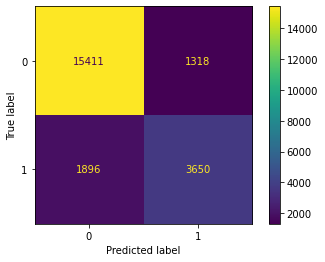

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()

plt.show()

#### ROC AUC

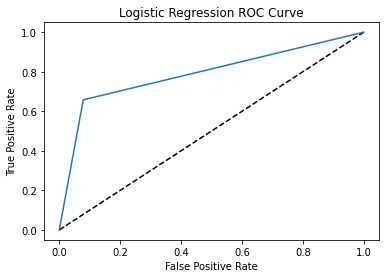

ROC under the curve is: 0.7896733220999046


In [28]:
y_score = dt.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print(f'ROC under the curve is: {auc}')

### FINAL PREDS TO EXPORT AND UPLOAD

In [19]:
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# Create OneHotEncoder: ohe
ohe = OneHotEncoder(sparse=False)
to_transform = ['property_type', 'bathrooms_cat', 'bedrooms_cat']
X = ohe.fit_transform(test[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names_out(to_transform))
test = pd.concat([test, X], axis=1)
test.drop(to_transform, axis=1, inplace=True)

In [22]:
X = train.drop('target', axis=1)
y = train['target']
test = test

In [31]:
test.columns

Index(['lat', 'lon', 'surface_total', 'pileta', 'vigilancia', 'patio',
       'garage', 'balcon', 'cancha', 'gimnasio', 'sauna', 'a_estrenar',
       'days_published', 'distance_shore', 'property_type_Apartamento',
       'property_type_Casa', 'property_type_Finca',
       'property_type_Local comercial', 'property_type_Lote',
       'property_type_Oficina', 'property_type_Otro',
       'property_type_Parqueadero', 'bathrooms_cat_0', 'bathrooms_cat_1',
       'bathrooms_cat_2', 'bathrooms_cat_3', 'bathrooms_cat_4',
       'bedrooms_cat_0', 'bedrooms_cat_1', 'bedrooms_cat_2', 'bedrooms_cat_3',
       'bedrooms_cat_4'],
      dtype='object')

In [32]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=14, random_state=1, criterion='entropy')

# Fit dt to the training set
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=1)

In [33]:
# Predict test set labels
y_pred = dt.predict(test)

y_pred.shape

(65850,)

In [ ]:
df = pd.DataFrame(y_pred, columns=['target'])
df.to_csv('./data/predictions/predictions_decision_tree.csv', index = False)

## STOCHASTIC GRADIENT DESCENT

In [39]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# Average CV score on the training set was: 0.862767529130213
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDClassifier(alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.25, learning_rate="invscaling", loss="log", penalty="elasticnet", power_t=50.0)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.8, min_samples_leaf=3, min_samples_split=6, n_estimators=100)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [40]:
exported_pipeline.score(X_test, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


0.868776655443322

In [44]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, results)

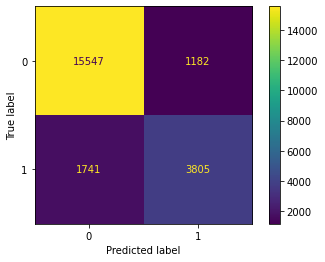

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay(matrix)

cm_display.plot()

plt.show()

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     16729
           1       0.76      0.69      0.72      5546

    accuracy                           0.87     22275
   macro avg       0.83      0.81      0.82     22275
weighted avg       0.87      0.87      0.87     22275



## SUPPORT VECTOR MACHINES

### Advantages

Effective in high dimensional spaces.

Still effective in cases where number of dimensions is greater than the number of samples.

Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.


## Disadvantages

It doesn't perform well when we have large data set because the required training time is higher.

If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

In [8]:
def make_meshgrid(x, y, h=.02, lims=None):
    """Create a mesh of points to plot in
    
    Parameters
    ----------
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional
        
    Returns
    -------
        xx, yy : ndarray
    """
    
    if lims is None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = lims
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, proba=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
    """
    if proba:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,-1]
        Z = Z.reshape(xx.shape)
        out = ax.imshow(Z,extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)), 
                        origin='lower', vmin=0, vmax=1, **params)
        ax.contour(xx, yy, Z, levels=[0.5])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_classifier(X, y, clf, ax=None, ticks=False, proba=False, lims=None): 
    # assumes classifier "clf" is already fit
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, lims=lims)
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
        show = True
    else:
        show = False
        
    # can abstract some of this into a higher-level function for learners to call
    cs = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8, proba=proba)
    if proba:
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel('probability of red $\Delta$ class', fontsize=20, rotation=270, labelpad=30)
        cbar.ax.tick_params(labelsize=14)
        #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors=\'k\', linewidth=1)
    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap=plt.cm.coolwarm, 
                   s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap=plt.cm.coolwarm, 
                   s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    #     ax.set_xlabel(data.feature_names[0])
    #     ax.set_ylabel(data.feature_names[1])
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
        #     ax.set_title(title)
    if show:
        plt.show()
    else:
        return ax

    def plot_4_classifiers(X, y, clfs):
    # Set-up 2x2 grid for plotting.
        fig, sub = plt.subplots(2, 2)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        
        for clf, ax, title in zip(clfs, sub.flatten(), ("(1)", "(2)", "(3)", "(4)")):
            # clf.fit(X, y)
            plot_classifier(X, y, clf, ax, ticks=True)
            ax.set_title(title)


    
from sklearn.tree import plot_tree
import mlxtend.plotting

def plot_labeled_decision_regions(X_test, y_test, clfs):
    
    for clf in clfs:

        mlxtend.plotting.plot_decision_regions(np.array(X_test), np.array(y_test), clf=clf, legend=2)
        
        plt.ylim((0,0.2))

        # Adding axes annotations
        plt.xlabel(X_test.columns[0])
        plt.ylabel(X_test.columns[1])
        plt.title(str(clf).split('(')[0])
        plt.show()

In [12]:
from sklearn.svm import SVC, LinearSVC
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1], 'kernel':['rbf', 'linear',]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

In [ ]:
from sklearn.svm import SVC, LinearSVC

# Set the regularization strength
model = SVC(C = 1, gamma = 0.0001, kernel = 'rbf')

# Fit and plot
model.fit(X_train,y_train)
plot_classifier(X_test,y_test,model)

## RANDOM FOREST

In [ ]:
class Experiment():
    
    def __init__(self, train, validation, target='target'):
        self.train = train
        self.validation = validation
        self.target = target
        
    def run(self):
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import mean_squared_error
        model = RandomForestClassifier(n_jobs=8, n_estimators=200)
        model.fit(self.train.drop(columns=[self.target]), self.train[self.target])
        preds = model.predict(self.validation.drop(columns=[self.target]))
        error = mean_squared_error(self.validation[target], preds, squared=False)
        return error

In [ ]:
%%time
experiment1 = Experiment(train, test)
experiment1.run()